In [1]:
import sys
dirname = '/Users/m.daffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt


In [2]:
ndoe = 200 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8*ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

In [3]:
kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 160
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.8501751
RMSE: 0.3371


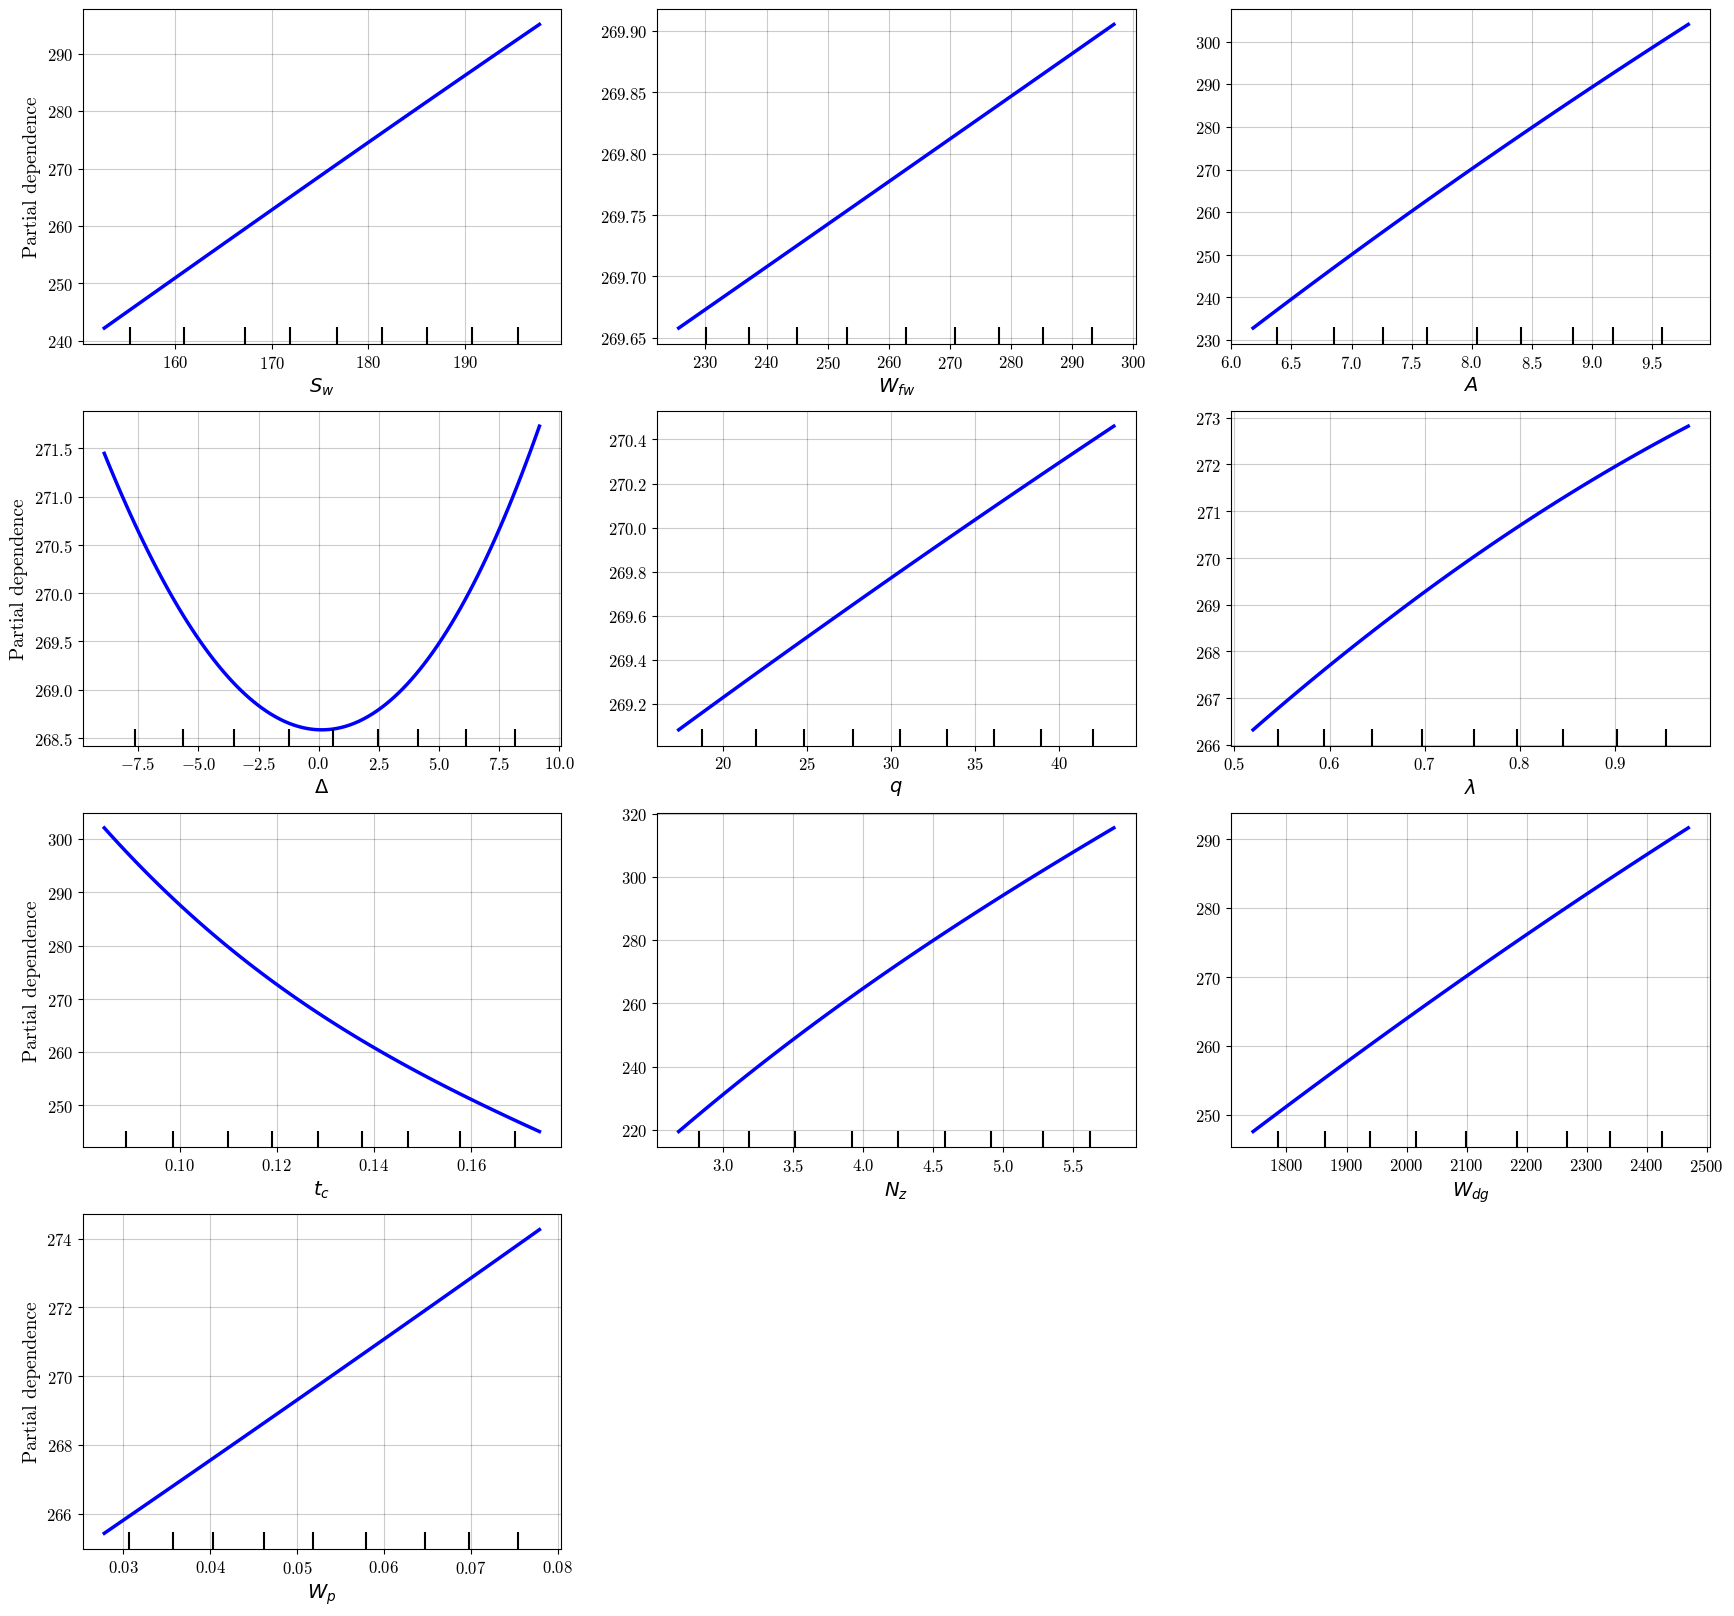

In [4]:
model = kriging_model
features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']
pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    grid_resolution=100, 
    kind='average',
    feature_names=feature_names,
    centered=False
    )

In [5]:
model = kriging_model
features = [3, (0, 1, 2)]
pd_results = partial_dependence(
    model, 
    X_tr, 
    features,
    method="sample",
)

ValueError: cannot reshape array of size 25600 into shape (160,160,160,160)

In [20]:
pd_results[0].keys()

dict_keys(['grid_values', 'average'])

In [1]:
def cartesian(arrays, out=None):
    """Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray of shape (M, len(arrays)), default=None
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray of shape (M, len(arrays))
        Array containing the cartesian products formed of input arrays.
        If not provided, the `dtype` of the output array is set to the most
        permissive `dtype` of the input arrays, according to NumPy type
        promotion.

        .. versionadded:: 1.2
           Add support for arrays of different types.

    Notes
    -----
    This function may not be used on more than 32 arrays
    because the underlying numpy functions do not support it.

    Examples
    --------
    >>> from sklearn.utils.extmath import cartesian
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """
    arrays = [np.asarray(x) for x in arrays]
    shape = (len(x) for x in arrays)

    ix = np.indices(shape)
    ix = ix.reshape(len(arrays), -1).T

    if out is None:
        dtype = np.result_type(*arrays)  # find the most permissive dtype
        if dtype.str[:2] != '<U':
            out = np.empty_like(ix, dtype=dtype)
        else:
            out = np.empty_like(ix, dtype='object')

    for n, arr in enumerate(arrays):
        out[:, n] = arrays[n][ix[:, n]]

    return out

In [21]:
def non_cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    
    ref = np.zeros((len(arrays[0]), len(arrays)))
    if out is None:
        out = np.empty_like(ref, dtype="object")

    for n, array in enumerate(arrays):
        out[:, n] = array
    return out


In [23]:
arrays = [[0, 1, 2], ["a", "h", "c"]]
arrays = [[0, 1, ], ["a", "h", "c"]]
non_cartesian(arrays)

ValueError: could not broadcast input array from shape (3,) into shape (2,)

In [13]:

ref

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [4]:
cartesian([[0, 1], [1, 2]])

array([[0, 1],
       [0, 2],
       [1, 1],
       [1, 2]])